In [1]:
# Libraries
from pathlib import Path
from matplotlib import pyplot as plt
from boutdata import collect
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution, Bernoulli
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from functools import reduce
from typing import *
import matplotlib
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
from collections import defaultdict
from eval_plots import plot_training_curves, visualize_reconstructions_live
from collections import defaultdict
from plotting import make_plasma_vae_plots

sns.set_style("whitegrid")

In [2]:
DATA_LOCATION = Path(
	r"data_numpy/density_large128.npy"
)

data = np.load(DATA_LOCATION)

In [3]:
# Normalize data
max_val = np.max(data)
density_data = data/max_val

In [ ]:
# Get the data in the correct format

data_tensor = torch.tensor(density_data, dtype=torch.float32)
data_tensor = data_tensor.unsqueeze(1)  # add channel dim: [N, 1, H, W]

print(data_tensor.shape) # Ensure data shape matches expectation!

# train and validation split
total_count = len(data_tensor)
train_size = int(0.8 * total_count)
test_size = total_count - train_size

# Split data_tensor (not data!) so batches have channel dimension
train_dataset, test_dataset = random_split(data_tensor, [train_size, test_size])

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([501, 1, 128, 128])


/var/folders/p0/74q9vxn91x9b906sr13d_ynw0000gn/T/ipykernel_65105/3864393536.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403210267/work/aten/src/ATen/native/TensorShape.cpp:3641.)
  plt.imshow(sample.T, origin='lower', cmap="viridis")


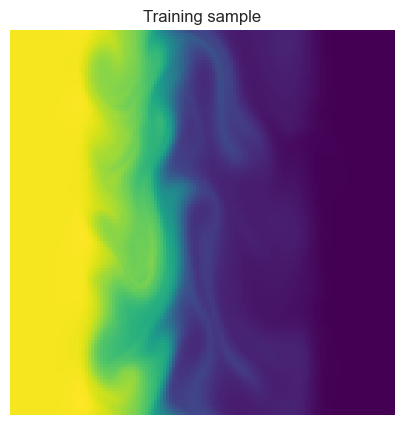

In [5]:
# Visualize a representative training sample
batch = next(iter(train_loader))
sample = batch[0]  # pick first image from batch (shape: H, W)
plt.figure(figsize=(5, 5))
plt.imshow(sample.T, origin='lower', cmap="viridis")
plt.title("Training sample")
plt.axis("off")
plt.show()

### Defining the VAE

Write some text here to explain it

In [6]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        epsilon = self.sample_epsilon()
        return self.mu + self.sigma * epsilon
            
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return -0.5 * (math.log(2 * math.pi) + 2 * torch.log(self.sigma) + ((z - self.mu) ** 2) / (self.sigma ** 2))


In [7]:
class ConvolutionalVariationalAutoencoder(nn.Module):
    def __init__(self, input_shape:torch.Size, latent_features: int, in_channels: int = 1) -> None:
        super().__init__()
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.in_channels = in_channels
        
        # Convolutional encoder keeps the code compact while extracting spatial features.
        self.conv_encoder = nn.Sequential(
            # Block 1: 128 -> 64
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # Block 2: 64 -> 32
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Block 3: 32 -> 16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Block 4: 16 -> 8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Flatten(),
            # Flattened size: 256 channels * 8 * 8 = 16384
            nn.Linear(256 * 8 * 8, latent_features * 2) 
        )

        
        self.conv_decoder = nn.Sequential(
            nn.Linear(latent_features, 256 * 8 * 8), # Upscale linear layer
            nn.Unflatten(dim=1, unflattened_size=(256, 8, 8)), # Reshape
            
            # Block 1: 8 -> 16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # Block 2: 16 -> 32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Block 3: 32 -> 64
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # Block 4: 64 -> 128
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
        # Prior parameters stay identical to the dense version.
        self.register_buffer("prior_params", torch.zeros(1, 2 * latent_features))

        # Define the learnable log-scale parameter
        self.log_scale = nn.Parameter(torch.tensor([0.0]))

        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""

        # compute the parameters of the posterior
        h_x = self.conv_encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)

        log_sigma = torch.clamp(log_sigma,min=-10, max=10)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        mu = self.conv_decoder(z)
        #scale = 0.1 # Fixed standard deviation #TODO. look at this
        scale = torch.exp(self.log_scale)
        return torch.distributions.Normal(mu, scale)
        
    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
        
    def sample_from_prior(self, batch_size: int = 16) -> Dict[str, Any]:
        pz = self.prior(batch_size=batch_size)
        z = pz.rsample()
        px = self.observation_model(z)
        return {"px": px, "pz": pz, "z": z}

# Example usage once you have tensors shaped as (batch, 1, H, W):

In [8]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl
        beta_elbo = log_px - self.beta * kl
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        

In [9]:
# Ensure the shape of the data so far
print(density_data[22,:,:].shape)
dummy = torch.tensor(data[22,:,:], dtype=torch.float32).clone()
print(dummy.shape)
dummy = dummy.unsqueeze(0).unsqueeze(0)

(128, 128)
torch.Size([128, 128])


### Testing and Validation

In [ ]:
# define the models, evaluator and optimizer

# CVAE
latent_features = 32
cvae = ConvolutionalVariationalAutoencoder(dummy.shape, latent_features)

# Evaluator: Variational Inference
beta = 0.75 # Might change
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3, weight_decay=1e-6)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

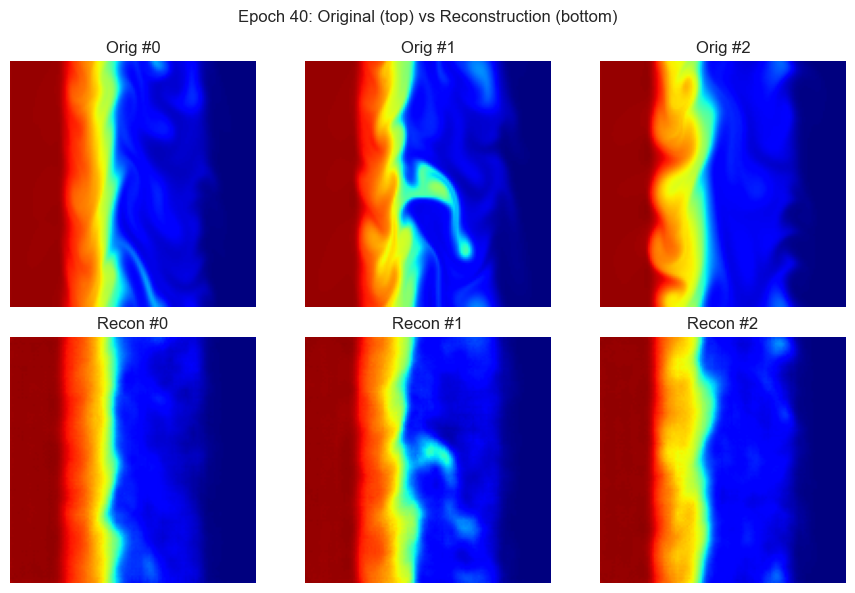

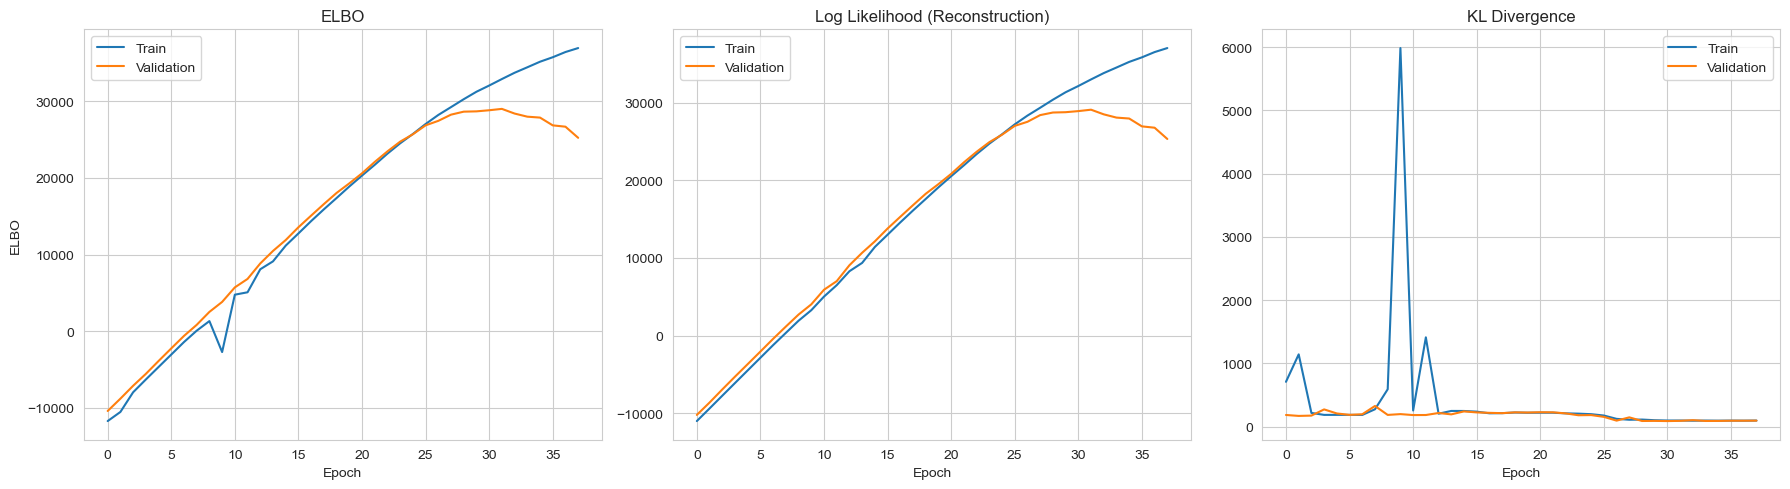

KeyboardInterrupt: 

In [ ]:
num_epochs = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
cvae = cvae.to(device)

best_val_elbo = -np.inf
patience = 10

# training..
epoch = 0
while epoch < num_epochs:
    epoch+= 1

    training_epoch_data = defaultdict(list)
    cvae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x in train_loader:
        x = x.to(device)

        # KL warm-up parameters
        kl_warmup_epochs = 30
        target_beta = 0.75  # your existing beta
        warmup_factor = min(1.0, epoch / float(kl_warmup_epochs))
        vi.beta = warmup_factor * target_beta

        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(cvae, x)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clip to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(cvae.parameters(), 1.0)

        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
      

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on the full test set, do not propagate gradients
    with torch.no_grad():
        cvae.eval()
        
        validation_epoch_data = defaultdict(list)
        
        # Iterate through the entire test loader
        for x in test_loader:
            x = x.to(device)
            
            # perform a forward pass through the model and compute the ELBO
            loss, diagnostics, outputs = vi(cvae, x)
            
            # gather data for the validation step
            for k, v in diagnostics.items():
                validation_epoch_data[k] += [v.mean().item()]
        
        # Average the metrics over the validation set and store
        for k, v in validation_epoch_data.items():
            validation_data[k] += [np.mean(v)]
    
    #print(f"{epoch} iterations completed")
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    if epoch % 10 == 0:
        #make_plasma_vae_plots(cvae, x, outputs, training_data, validation_data)
        clear_output(wait=True)
        train_vis = {k: v[2:] for k, v in training_data.items()}
        val_vis = {k: v[2:] for k, v in validation_data.items()}
        visualize_reconstructions_live(cvae, test_loader, device, epoch, num_samples=3, cmap='viridis', transpose=True)
        
        plot_training_curves(train_vis, val_vis)
    
    # Track best validation loss (lower is better)

    val_metric = np.mean(validation_epoch_data['elbo'])  # or use -elbo if maximizing
    if val_metric > best_val_elbo:
        best_val_elbo = val_metric
        epochs_without_improve = 0
        torch.save({
            'model_state_dict': cvae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'latent_features': latent_features,
            'beta': target_beta
        }, 'best_cvae.pt')
    else:
        epochs_without_improve += 1

    if epochs_without_improve >= patience:
        print(f"\n{'='*60}")
        print(f"Early stopping triggered at epoch {epoch}")
        print(f"Best validation ELBO: {best_val_elbo:.4f}")
        print(f"Training stopped after {epoch} epochs (patience={patience})")
        print(f"{'='*60}\n")
        break

In [ ]:
# Save trained model
model_save_path = Path("trained_cvae_model.pt")
torch.save({
    'model_state_dict': cvae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'latent_features': latent_features,
    'beta': beta,
    'epoch': epoch,
    'training_data': dict(training_data),
    'validation_data': dict(validation_data)
}, model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to trained_cvae_model.pt


In [ ]:
# Print training summary after completion
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"Total epochs trained: {epoch}")
print(f"Best validation ELBO: {best_val_elbo:.4f}")
print(f"Final training loss: {training_data['elbo'][-1]:.4f}")
print(f"Final validation loss: {validation_data['elbo'][-1]:.4f}")
print(f"Best model saved at: best_cvae.pt")
print("="*70 + "\n")


In [ ]:
# Load trained model
model_load_path = Path("trained_cvae_model.pt")

if model_load_path.exists():
    checkpoint = torch.load(model_load_path)
    
    # Reconstruct model with same architecture
    latent_features = checkpoint['latent_features']
    beta = checkpoint['beta']
    
    cvae = ConvolutionalVariationalAutoencoder(dummy.shape, latent_features)
    cvae.load_state_dict(checkpoint['model_state_dict'])
    cvae = cvae.to(device)
    
    # Optionally load optimizer state for continued training
    optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Load training history
    training_data = checkpoint['training_data']
    validation_data = checkpoint['validation_data']
    epoch = checkpoint['epoch']
    
    print(f"Model loaded from {model_load_path}")
    print(f"Trained for {epoch} epochs")
    print(f"Latent features: {latent_features}, Beta: {beta}")
else:
    print(f"Model file not found at {model_load_path}")
